In [2]:
from tools import *
import matplotlib.pyplot as plt
import tools
import pept3
import os
import seaborn as sns
import numpy as np
import torch
import re
import pandas as pd
from tqdm import tqdm
from importlib import reload
import bio_helper
import sys
import random
from collections import defaultdict
sys.path.append("..")
%load_ext autoreload
%autoreload 2
reload(bio_helper)

<module 'bio_helper' from '/home/gus/Desktop/ms_pred/figs/bio_helper.py'>

In [3]:
name, msms_data = tools.read_msms(
    f"/data/prosit/figs/fig235/gluc/maxquant/combined/txt/msms.txt")
msms_data = tools.filter_msms(name, msms_data)

msms_data = random.sample(msms_data, 100000)

msms_data.sort(key=lambda x: int(x[name.index("id")]))
m_r = loc_msms_in_raw(msms_data, f"/data/prosit/figs/fig235/gluc/raw")
m_r = sorted(m_r, key=lambda x: int(x[0][name.index("id")]))

peptides = [i[0][name.index("Modified sequence")].replace("_", "") for i in m_r]
scores = [float(m[0][name.index("Score")]) for m in m_r]
label = [0 if m[0][name.index("Reverse")] else 1 for m in m_r]

In [4]:
matched_ions_pre = generate_matched_ions(m_r)
m_i = [bio_helper.match_all(i, 'yb') for i in tqdm(matched_ions_pre)]
frag_msms = [bio_helper.reverse_annotation(*i[:4]) for i in tqdm(m_i)]
data_nce_cand = generate_from_mi(matched_ions_pre, name, nces=33)

100%|██████████| 100000/100000 [00:02<00:00, 35785.56it/s]


In [5]:
from pept3 import model

run_model = model.PrositFrag()
run_model.load_state_dict(torch.load(
    "../checkpoints/best/best_valid_irt_PrositFrag-1024.pth", map_location="cpu"))
prosit = run_model.eval()

In [6]:
prosit_sa, _ = get_sa_all(prosit, data_nce_cand, frag_msms)
prosit_sa = prosit_sa.cpu().numpy()

In [13]:
print(len(peptides), len(set(peptides)))

100000 86436


In [8]:
peptides_len = [len(list(bio_helper.peptide_parser(i))) for i in peptides]
charges = [i['charge'] for i in matched_ions_pre]

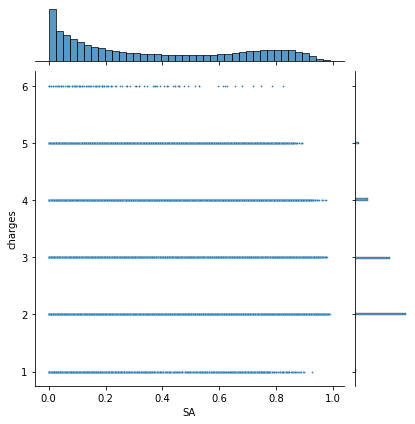

In [9]:
joint_pd = pd.DataFrame({"charges": charges, "SA": prosit_sa})
ax = sns.jointplot(x="SA", y='charges', data=joint_pd, s=3)

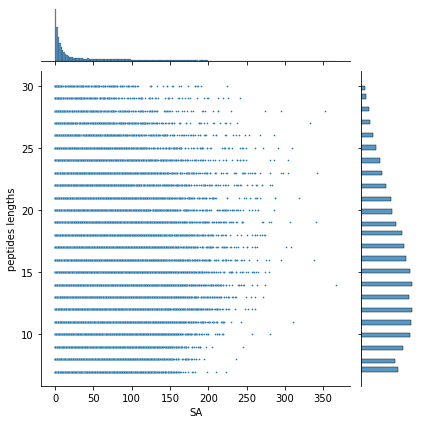

In [14]:
joint_pd = pd.DataFrame({"peptides lengths": peptides_len, "SA": scores})
ax = sns.jointplot(x="SA", y='peptides lengths', data=joint_pd, s=3)

In [11]:
peptides_scores = defaultdict(list)
peptides_charges = defaultdict(list)
peptides_labels = {}
for p, s, l, c in zip(peptides, prosit_sa, label, charges):
    peptides_scores[(p,c)].append(s)
    peptides_labels[(p,c)] = l
    peptides_charges[p].append(c)

<AxesSubplot:xlabel='#PSMs per Peptide-Charge pair', ylabel='Count'>

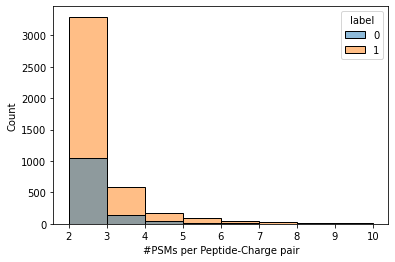

In [15]:
occur_peptides_leng = np.array([len(peptides_scores[i]) for i in list(peptides_scores)])
occur_peptides_label = np.array([peptides_labels[i] for i in list(peptides_scores)])

joint_pd = pd.DataFrame({"label": occur_peptides_label, "#PSMs per Peptide-Charge pair": occur_peptides_leng})
# ax = sns.jointplot(x="label", y='length', data=joint_pd)
sns.histplot(x="#PSMs per Peptide-Charge pair",data=joint_pd, hue="label", binwidth=1, binrange=(2, 10))

In [23]:


# joint_pd = pd.DataFrame({"label": occur_peptides_label, "PSMs per Peptide": occur_peptides_leng})
# # ax = sns.jointplot(x="label", y='length', data=joint_pd)
# sns.histplot(x="PSMs per Peptide",data=joint_pd, hue="label", binwidth=1, binrange=(2, 10))

[0.08900433056152801, 0.15476440091913568]
[4, 5]
--
[0.9171412809174725, 0.7997691606390024]
[2, 3]
--
[0.8679011329434967, 0.9273623186232136]
[3, 2]
--
[0.8950570136076486, 0.7860289172425917]
[2, 3]
--
[0.8224885315471971, 0.7795720075817119]
[2, 3]
--
[0.6295395164916018, 0.802410470931094]
[3, 2]
--
[0.8548660921078781, 0.8550613705495684]
[3, 3]
--
[0.9168382810427448, 0.06846599963636091]
[2, 2]
--
[0.5250652232748068, 0.7706946247240083]
[2, 3]
--
[0.7947307852363614, 0.6437606425393236]
[2, 4]
--
[0.8585261501946001, 0.8629087622447815]
[3, 2]
--
[0.8904427913029651, 0.8142566578372905]
[4, 3]
--
[0.8761159036551115, 0.8536039516259488]
[3, 3]
--
[0.034133648690791385, 0.09521729991416339]
[2, 5]
--
[0.7127227187299117, 0.9421650966658286]
[3, 2]
--
[0.8678311499658242, 0.7179671058569245]
[3, 4]
--
[0.8201914581076847, 0.8613095444663863]
[3, 2]
--
[0.9151092604070417, 0.827891487317059]
[3, 2]
--
[0.8314614271152718, 0.661567223562368]
[2, 2]
--
[0.652033258724996, 0.600733